### Using Transfer Learning to Fine Tune a YOLOv8n model as a One-Stage SDetector for Playing Cards

In [1]:
from ultralytics import YOLO
import torch
import matplotlib.pyplot as plt
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Preprocessing the Data - Visualization, Normalization, and Information

1. Show Basic Class Information

In [2]:
import yaml

dataset_path = r"C:\Users\jacob\yolo-card-dataset"
with open(os.path.join(dataset_path, 'data.yaml'), 'r') as file:
    data_config = yaml.safe_load(file)

print("Dataset Configuration:")
print(f"Number of classes: {data_config['nc']}")
print(f"Class names: {data_config['names']}")
print(f"Train path: {data_config['train']}")
print(f"Val path: {data_config['val']}")

Dataset Configuration:
Number of classes: 52
Class names: ['10c', '10d', '10h', '10s', '2c', '2d', '2h', '2s', '3c', '3d', '3h', '3s', '4c', '4d', '4h', '4s', '5c', '5d', '5h', '5s', '6c', '6d', '6h', '6s', '7c', '7d', '7h', '7s', '8c', '8d', '8h', '8s', '9c', '9d', '9h', '9s', 'Ac', 'Ad', 'Ah', 'As', 'Jc', 'Jd', 'Jh', 'Js', 'Kc', 'Kd', 'Kh', 'Ks', 'Qc', 'Qd', 'Qh', 'Qs']
Train path: ../train/images
Val path: ../valid/images


2. Visualize the Images and their Labels (Bounding Boxes)

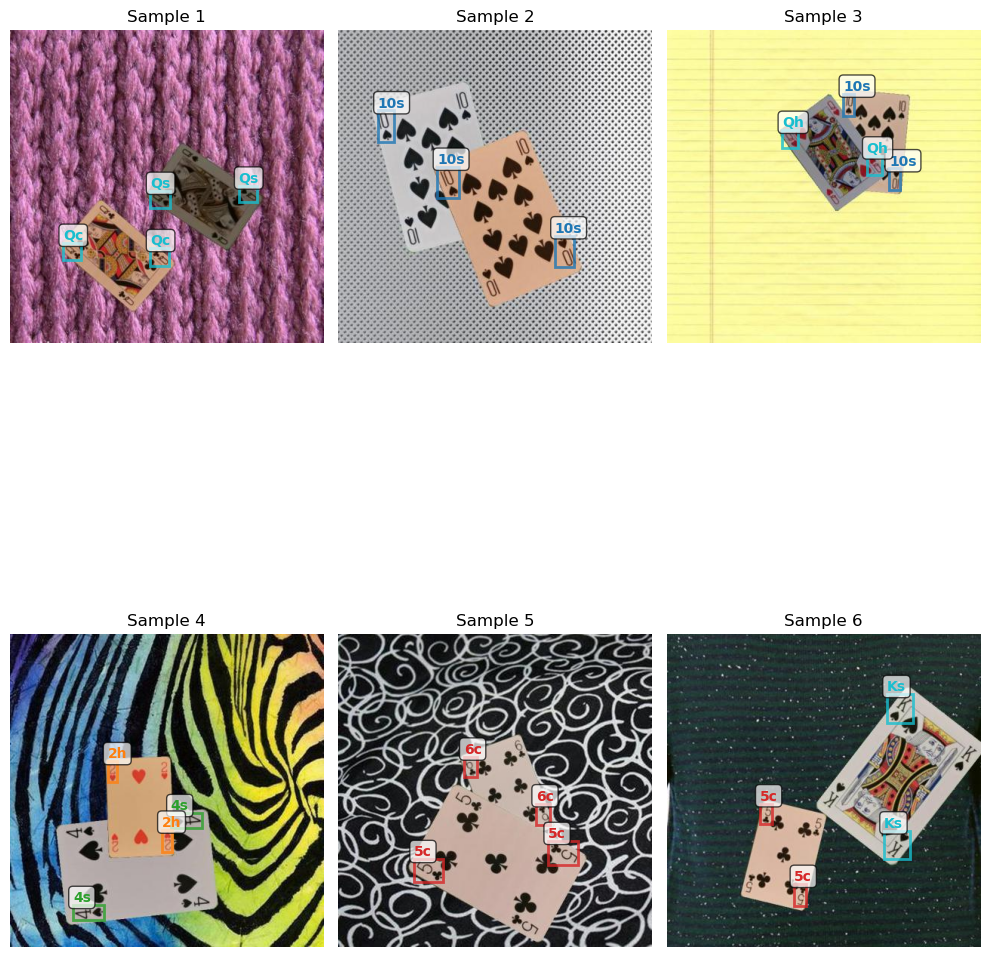

In [4]:
import random
import cv2
import numpy as np
import matplotlib.patches as patches

def load_yolo_annotations(label_path):
    """Load YOLO format annotations from a text file"""
    annotations = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])
                    annotations.append([class_id, x_center, y_center, width, height])
    return annotations



def coords_to_box(yolo_coords, img_width, img_height):
    class_id, x_center, y_center, width, height = yolo_coords

    x1 = int((x_center - width/2) * img_width)
    y1 = int((y_center - height/2) * img_height)
    x2 = int((x_center + width/2) * img_width)
    y2 = int((y_center + height/2) * img_height)

    return x1, y1, x2, y2

def visualize_sample_imgs(image_dir, label_dir, class_names, num_samples=6):

    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))

    fig, axes = plt.subplots(2, 3, figsize=(10, 15))
    axes = axes.flatten()

    for idx, img_file in enumerate(sample_files):

        img_path = os.path.join(image_dir, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label_file = img_file.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(label_dir, label_file)
        annotations = load_yolo_annotations(label_path)

        axes[idx].imshow(image)
        axes[idx].set_title(f'Sample {idx+1}')
        axes[idx].axis('off')

        h, w = image.shape[:2]
        colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)))

        for ann in annotations:
            x1, y1, x2, y2 = coords_to_box(ann, w, h)
            class_id = int(ann[0])

            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                   linewidth=2, edgecolor=colors[class_id], 
                                   facecolor='none', alpha=0.8)
            axes[idx].add_patch(rect)

            axes[idx].text(x1, y1-5, class_names[class_id], 
                          color=colors[class_id], fontsize=10, fontweight='bold',
                          bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))
    plt.tight_layout()
    plt.show()





#get samples from train folder
train_images = os.path.join(dataset_path, 'train', 'images')
train_labels = os.path.join(dataset_path, 'train', 'labels')

if os.path.exists(train_images) and os.path.exists(train_labels):
    visualize_sample_imgs(train_images, train_labels, data_config['names'])
else:
    print("Train images or labels directory not found")



3. Dataset Statistics

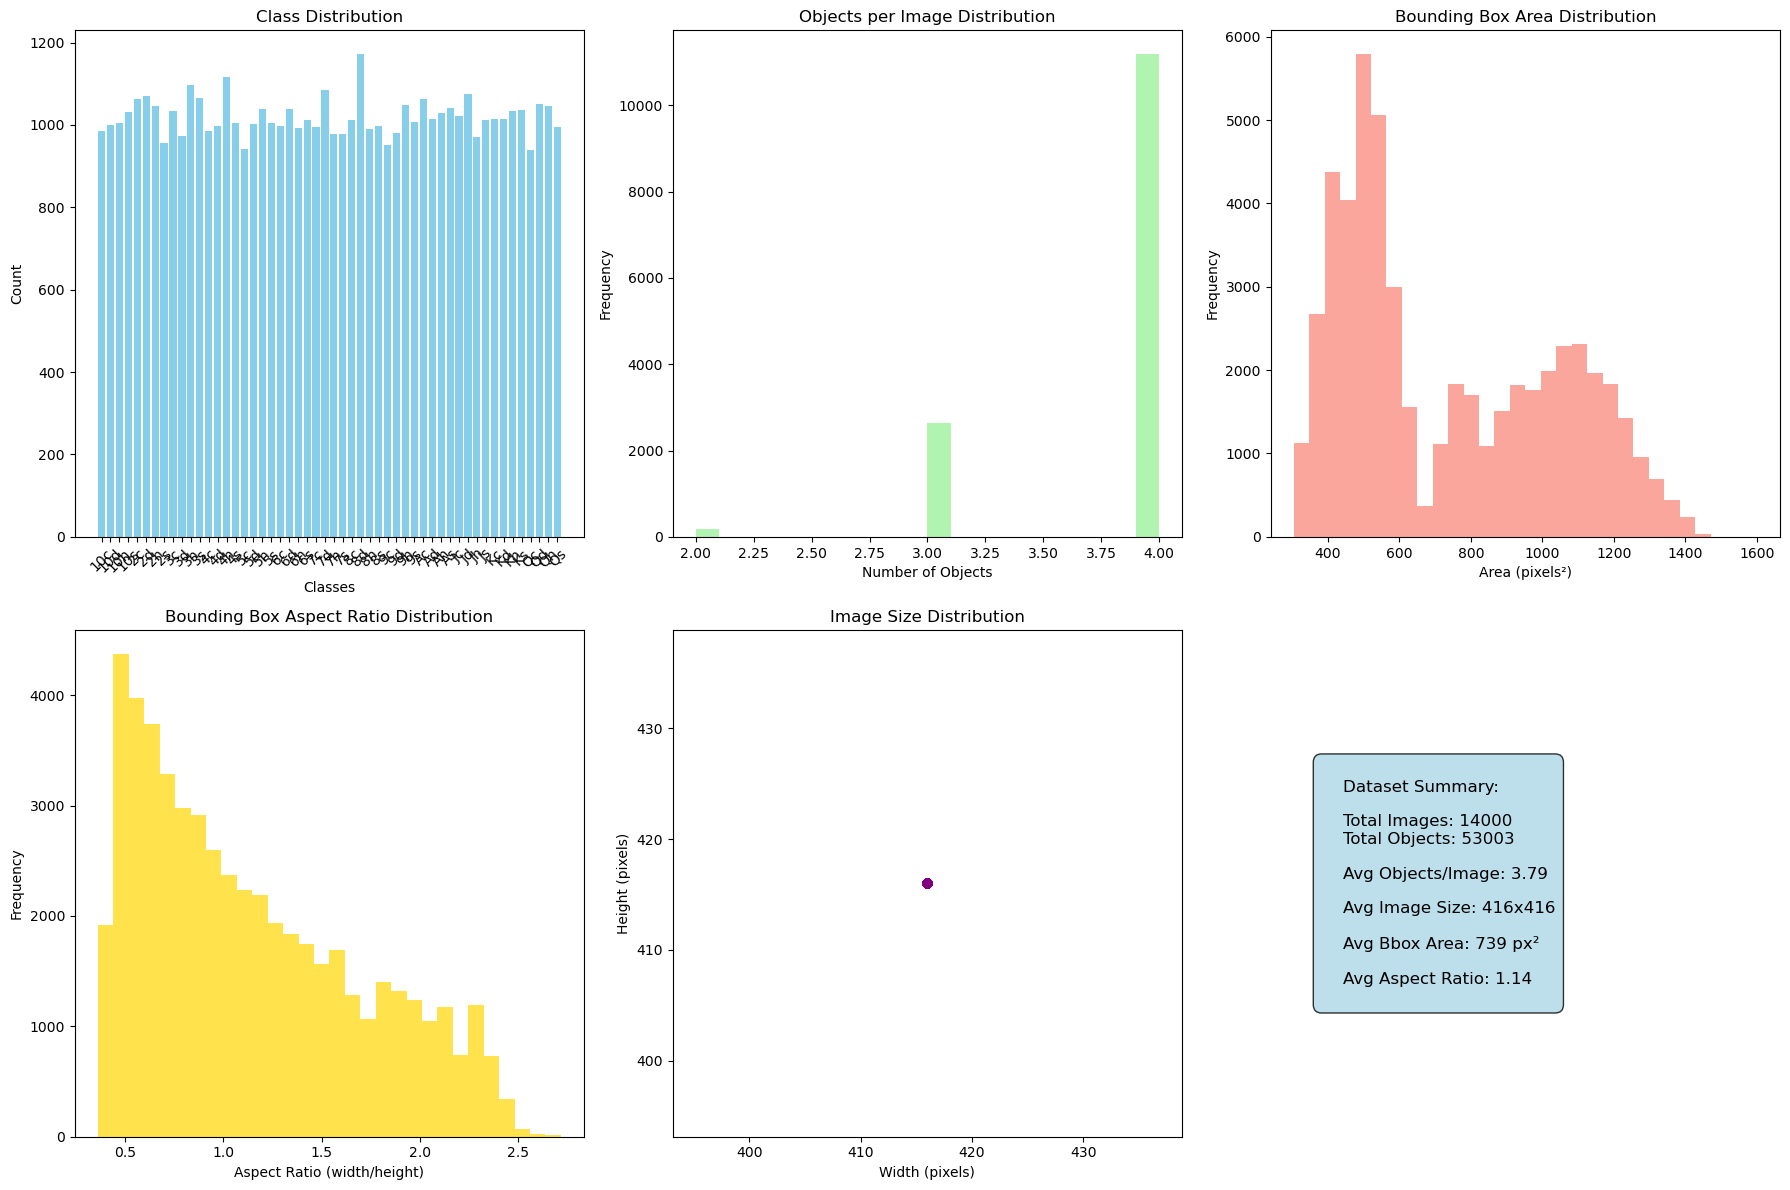

In [ ]:
from collections import Counter

def analyze_dataset_statistics(image_dir, label_dir, class_names):
    """Analyze and visualize dataset statistics"""
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Statistics containers
    class_counts = Counter()
    bbox_areas = []
    bbox_aspect_ratios = []
    image_sizes = []
    objects_per_image = []
    
    for img_file in image_files:
        #load image to get dimensions
        img_path = os.path.join(image_dir, img_file)
        image = cv2.imread(img_path)
        h, w = image.shape[:2]
        image_sizes.append((w, h))
        
        label_file = img_file.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(label_dir, label_file)
        annotations = load_yolo_annotations(label_path)
        
        objects_per_image.append(len(annotations))
        
        for ann in annotations:
            class_id = int(ann[0])
            class_counts[class_id] += 1
            
            #calculate bbox properties
            width = ann[3] * w
            height = ann[4] * h
            area = width * height
            aspect_ratio = width / height if height > 0 else 0
            
            bbox_areas.append(area)
            bbox_aspect_ratios.append(aspect_ratio)
    
    #create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    #class distribution
    classes = [class_names[i] for i in sorted(class_counts.keys())]
    counts = [class_counts[i] for i in sorted(class_counts.keys())]
    
    axes[0, 0].bar(classes, counts, color='skyblue')
    axes[0, 0].set_title('Class Distribution')
    axes[0, 0].set_xlabel('Classes')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    #objects per image
    axes[0, 1].hist(objects_per_image, bins=20, color='lightgreen', alpha=0.7)
    axes[0, 1].set_title('Objects per Image Distribution')
    axes[0, 1].set_xlabel('Number of Objects')
    axes[0, 1].set_ylabel('Frequency')
    
    #bounding box areas
    axes[0, 2].hist(bbox_areas, bins=30, color='salmon', alpha=0.7)
    axes[0, 2].set_title('Bounding Box Area Distribution')
    axes[0, 2].set_xlabel('Area (pixels²)')
    axes[0, 2].set_ylabel('Frequency')
    
    #bounding box aspect ratios
    axes[1, 0].hist(bbox_aspect_ratios, bins=30, color='gold', alpha=0.7)
    axes[1, 0].set_title('Bounding Box Aspect Ratio Distribution')
    axes[1, 0].set_xlabel('Aspect Ratio (width/height)')
    axes[1, 0].set_ylabel('Frequency')
    
    #image sizes
    widths, heights = zip(*image_sizes)
    axes[1, 1].scatter(widths, heights, alpha=0.6, color='purple')
    axes[1, 1].set_title('Image Size Distribution')
    axes[1, 1].set_xlabel('Width (pixels)')
    axes[1, 1].set_ylabel('Height (pixels)')
    
    #summary statistics
    axes[1, 2].axis('off')
    stats_text = f"""
    Dataset Summary:
    
    Total Images: {len(image_files)}
    Total Objects: {sum(class_counts.values())}
    
    Avg Objects/Image: {np.mean(objects_per_image):.2f}
    
    Avg Image Size: {np.mean(widths):.0f}x{np.mean(heights):.0f}
    
    Avg Bbox Area: {np.mean(bbox_areas):.0f} px²
    
    Avg Aspect Ratio: {np.mean(bbox_aspect_ratios):.2f}
    """
    axes[1, 2].text(0.1, 0.5, stats_text, transform=axes[1, 2].transAxes, 
                    fontsize=12, verticalalignment='center',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return {
        'class_counts': class_counts,
        'objects_per_image': objects_per_image,
        'bbox_areas': bbox_areas,
        'bbox_aspect_ratios': bbox_aspect_ratios,
        'image_sizes': image_sizes
    }

stats = analyze_dataset_statistics(train_images, train_labels, data_config['names'])

### Now to Training - Yolov8n Model

In [11]:
model = YOLO('yolov8n.pt')

model.train(
    data=r"C:\Users\jacob\yolo-card-dataset\data.yaml", 
    imgsz=640, 
    batch=16,  # You could try increasing to 32 if you have enough GPU memory
    epochs=50,  # Reduced from 100 - often sufficient for good results
    patience=10,  # Early stopping if no improvement for 10 epochs
    device=device,
    workers=4,  # Parallel data loading
    cache=True,  # Cache images in RAM for faster loading
    save_period=10,  # Save checkpoint every 10 epochs
    amp=True  # Automatic Mixed Precision for faster training
)

New https://pypi.org/project/ultralytics/8.3.223 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=C:\Users\jacob\yolo-card-dataset\data.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=10, cache=True, device=cuda:0, workers=4, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

train: Scanning C:\Users\jacob\yolo-card-dataset\train\labels.cache... 14000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14000/14000 [00:00<?, ?it/s]


WARNING train: 24.0GB RAM required to cache images with 50% safety margin but only 2.1/15.8GB available, not caching images
val: Fast image access  (ping: 4.95.5 ms, read: 1.50.7 MB/s, size: 31.8 KB)


val: Scanning C:\Users\jacob\yolo-card-dataset\valid\labels.cache... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:00<?, ?it/s]


WARNING val: 6.9GB RAM required to cache images with 50% safety margin but only 0.7/15.8GB available, not caching images
Plotting labels to runs\detect\train5\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.12G       1.01      3.957     0.9361         77        640: 100%|██████████| 875/875 [49:32<00:00,  3.40s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [10:24<00:00,  4.99s/it]


                   all       4000      15159      0.178      0.483      0.202       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.83G      0.808      2.247     0.8882         72        640: 100%|██████████| 875/875 [14:24<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [12:01<00:00,  5.77s/it]


                   all       4000      15159      0.617      0.761      0.753      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.79G      0.789      1.577     0.8876         73        640: 100%|██████████| 875/875 [11:39<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:22<00:00,  3.06s/it]


                   all       4000      15159      0.817      0.877       0.91      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.77G     0.7344      1.195     0.8781         69        640: 100%|██████████| 875/875 [15:19<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:50<00:00,  3.29s/it]


                   all       4000      15159      0.848      0.915      0.929       0.82

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.79G     0.6716     0.9397     0.8644         88        640: 100%|██████████| 875/875 [15:09<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [07:03<00:00,  3.39s/it]


                   all       4000      15159      0.909      0.936      0.958      0.849

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.82G       0.63     0.7877     0.8579         91        640: 100%|██████████| 875/875 [16:51<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:24<00:00,  3.08s/it]

                   all       4000      15159      0.931       0.97      0.972      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.79G     0.6032     0.6961     0.8505         96        640: 100%|██████████| 875/875 [15:17<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:57<00:00,  3.34s/it]

                   all       4000      15159      0.932      0.975      0.973      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.79G     0.5842     0.6296     0.8442        104        640: 100%|██████████| 875/875 [11:31<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:40<00:00,  3.20s/it]

                   all       4000      15159      0.939      0.979      0.978       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.79G     0.5639     0.5903     0.8417         87        640: 100%|██████████| 875/875 [11:31<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:54<00:00,  3.32s/it]

                   all       4000      15159      0.939      0.977      0.978      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.79G     0.5558     0.5582     0.8383         81        640: 100%|██████████| 875/875 [15:14<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:25<00:00,  3.08s/it]

                   all       4000      15159       0.95      0.979      0.981      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.82G     0.5446     0.5336     0.8375         87        640: 100%|██████████| 875/875 [16:25<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:33<00:00,  3.15s/it]

                   all       4000      15159      0.943      0.987       0.98      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.78G     0.5388     0.5167     0.8353         90        640: 100%|██████████| 875/875 [15:16<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:24<00:00,  3.08s/it]

                   all       4000      15159      0.947      0.985      0.981      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.79G     0.5274      0.496     0.8341         50        640: 100%|██████████| 875/875 [11:44<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [05:57<00:00,  2.86s/it]

                   all       4000      15159      0.943      0.989      0.981      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.79G      0.517     0.4792     0.8309         91        640: 100%|██████████| 875/875 [11:37<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [05:55<00:00,  2.85s/it]

                   all       4000      15159      0.949      0.991      0.982      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.79G     0.5129     0.4701     0.8284        109        640: 100%|██████████| 875/875 [11:36<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [05:56<00:00,  2.85s/it]


                   all       4000      15159      0.941      0.995      0.979      0.911

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.79G     0.5052     0.4622     0.8277         95        640: 100%|██████████| 875/875 [11:35<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:21<00:00,  3.05s/it]

                   all       4000      15159      0.954      0.985      0.983      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.78G     0.4995     0.4497     0.8258         78        640: 100%|██████████| 875/875 [15:20<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:24<00:00,  3.08s/it]

                   all       4000      15159       0.96       0.98      0.984      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.78G      0.495     0.4381     0.8238         75        640: 100%|██████████| 875/875 [15:15<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:25<00:00,  3.08s/it]

                   all       4000      15159      0.956      0.987      0.984       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.79G      0.487     0.4338     0.8241         91        640: 100%|██████████| 875/875 [11:36<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:21<00:00,  3.05s/it]

                   all       4000      15159      0.949      0.994      0.982      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.77G     0.4852     0.4275     0.8221         61        640: 100%|██████████| 875/875 [11:35<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:15<00:00,  3.00s/it]


                   all       4000      15159      0.949      0.995      0.982      0.919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.82G     0.4791     0.4156     0.8216         77        640: 100%|██████████| 875/875 [16:21<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:28<00:00,  3.11s/it]

                   all       4000      15159      0.956      0.989      0.984      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.79G     0.4747     0.4085     0.8199         93        640: 100%|██████████| 875/875 [11:33<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [05:48<00:00,  2.79s/it]

                   all       4000      15159      0.962      0.985      0.985       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.82G     0.4696     0.4032      0.819         74        640: 100%|██████████| 875/875 [16:21<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:28<00:00,  3.11s/it]

                   all       4000      15159      0.957      0.988      0.984      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.79G     0.4677     0.3979     0.8187         97        640: 100%|██████████| 875/875 [11:30<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [05:49<00:00,  2.80s/it]

                   all       4000      15159      0.968      0.983      0.986      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.79G     0.4607     0.3921     0.8179         77        640: 100%|██████████| 875/875 [15:12<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:19<00:00,  3.03s/it]

                   all       4000      15159       0.96      0.987      0.985      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.77G     0.4575     0.3867     0.8167        105        640: 100%|██████████| 875/875 [15:15<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:20<00:00,  3.04s/it]

                   all       4000      15159      0.966      0.985      0.986      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.78G     0.4525     0.3821     0.8153         81        640: 100%|██████████| 875/875 [15:13<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:18<00:00,  3.02s/it]

                   all       4000      15159      0.966      0.986      0.987      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.79G     0.4497     0.3751      0.816         89        640: 100%|██████████| 875/875 [11:31<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:48<00:00,  3.26s/it]

                   all       4000      15159      0.967      0.987      0.987      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.79G     0.4456     0.3709     0.8144         99        640: 100%|██████████| 875/875 [11:33<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:15<00:00,  3.01s/it]

                   all       4000      15159      0.972      0.985      0.988      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.77G     0.4419     0.3672     0.8139         86        640: 100%|██████████| 875/875 [11:34<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:15<00:00,  3.00s/it]

                   all       4000      15159       0.97      0.986      0.988      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.79G     0.4394     0.3619     0.8126        108        640: 100%|██████████| 875/875 [11:33<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [05:50<00:00,  2.80s/it]

                   all       4000      15159      0.973      0.985      0.988      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.77G     0.4352     0.3574      0.813         99        640: 100%|██████████| 875/875 [11:33<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:15<00:00,  3.00s/it]

                   all       4000      15159      0.973      0.985      0.988       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.78G     0.4322     0.3529     0.8122         93        640: 100%|██████████| 875/875 [15:15<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:20<00:00,  3.04s/it]

                   all       4000      15159       0.97      0.988      0.988      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.78G     0.4287     0.3472     0.8104         79        640: 100%|██████████| 875/875 [15:16<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:21<00:00,  3.05s/it]

                   all       4000      15159      0.977      0.984      0.989      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.79G     0.4246     0.3427     0.8103         75        640: 100%|██████████| 875/875 [11:32<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [05:50<00:00,  2.80s/it]

                   all       4000      15159      0.972      0.986      0.988      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.79G     0.4222     0.3409     0.8093         80        640: 100%|██████████| 875/875 [11:33<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:15<00:00,  3.01s/it]

                   all       4000      15159      0.974      0.986      0.989      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.79G     0.4182     0.3327     0.8102         76        640: 100%|██████████| 875/875 [11:32<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:14<00:00,  3.00s/it]

                   all       4000      15159      0.969       0.99      0.988      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.78G     0.4136     0.3298     0.8086         81        640: 100%|██████████| 875/875 [15:11<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [07:19<00:00,  3.51s/it]

                   all       4000      15159      0.976      0.985      0.989      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.82G     0.4125     0.3271     0.8077         80        640: 100%|██████████| 875/875 [16:16<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:25<00:00,  3.08s/it]

                   all       4000      15159      0.975      0.988       0.99      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.79G     0.4096     0.3217     0.8076         86        640: 100%|██████████| 875/875 [15:09<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:18<00:00,  3.02s/it]

                   all       4000      15159      0.975      0.986      0.989      0.948


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.75G     0.3762     0.2582     0.8014         61        640: 100%|██████████| 875/875 [14:14<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [08:01<00:00,  3.85s/it]

                   all       4000      15159      0.975      0.987      0.989       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.75G     0.3691     0.2508     0.8012         63        640: 100%|██████████| 875/875 [15:36<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [08:34<00:00,  4.12s/it]


                   all       4000      15159      0.974      0.989       0.99      0.951

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.75G     0.3635     0.2462     0.7997         59        640: 100%|██████████| 875/875 [17:29<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [08:50<00:00,  4.24s/it]


                   all       4000      15159      0.974       0.99       0.99      0.952

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.75G       0.36     0.2413     0.7983         63        640: 100%|██████████| 875/875 [14:51:39<00:00, 61.14s/it]        
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [10:53<00:00,  5.23s/it]


                   all       4000      15159      0.974      0.993       0.99      0.953

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.75G     0.3571     0.2374     0.7986         59        640: 100%|██████████| 875/875 [09:15<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [06:21<00:00,  3.05s/it]

                   all       4000      15159      0.975      0.992       0.99      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.75G      0.353     0.2316     0.7986         52        640: 100%|██████████| 875/875 [13:11<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [09:52<00:00,  4.74s/it]


                   all       4000      15159      0.975      0.991       0.99      0.954

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.75G     0.3505      0.228     0.7978         61        640: 100%|██████████| 875/875 [17:16<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [08:31<00:00,  4.09s/it]

                   all       4000      15159      0.977       0.99      0.991      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.75G     0.3479     0.2251      0.796         58        640: 100%|██████████| 875/875 [14:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [08:03<00:00,  3.87s/it]

                   all       4000      15159      0.981      0.986      0.991      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.75G     0.3447     0.2209     0.7952         59        640: 100%|██████████| 875/875 [15:16<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [08:08<00:00,  3.90s/it]

                   all       4000      15159      0.978       0.99      0.991      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.75G     0.3413     0.2174     0.7945         62        640: 100%|██████████| 875/875 [13:55<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [08:55<00:00,  4.28s/it]

                   all       4000      15159      0.978      0.991      0.991      0.955



50 epochs completed in 32.581 hours.
Optimizer stripped from runs\detect\train5\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\train5\weights\best.pt, 6.3MB

Validating runs\detect\train5\weights\best.pt...
Ultralytics 8.3.122  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1650 with Max-Q Design, 4096MiB)
Model summary (fused): 72 layers, 3,015,788 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [01:22<00:00,  1.51it/s]


                   all       4000      15159      0.978       0.99      0.991      0.955
                   10c        180        282      0.998          1      0.995      0.915
                   10d        188        290      0.998          1      0.995      0.922
                   10h        201        322      0.998          1      0.995      0.938
                   10s        165        250      0.998          1      0.995      0.924
                    2c        193        295      0.998          1      0.995      0.967
                    2d        167        259      0.998          1      0.995      0.962
                    2h        187        294          1          1      0.995      0.954
                    2s        192        299      0.998          1      0.995      0.962
                    3c        201        308      0.998          1      0.995      0.972
                    3d        167        250      0.994          1      0.995      0.967
                    3

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001F8E5961580>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.0

Validate the model

Testing on: 946641658_jpg.rf.64e9637f9539dc5a7457db362304afc0.jpg

image 1/1 C:\Users\jacob\yolo-card-dataset\valid\images\946641658_jpg.rf.64e9637f9539dc5a7457db362304afc0.jpg: 640x640 2 3ss, 4 Acs, 82.1ms
Speed: 11.0ms preprocess, 82.1ms inference, 12.6ms postprocess per image at shape (1, 3, 640, 640)


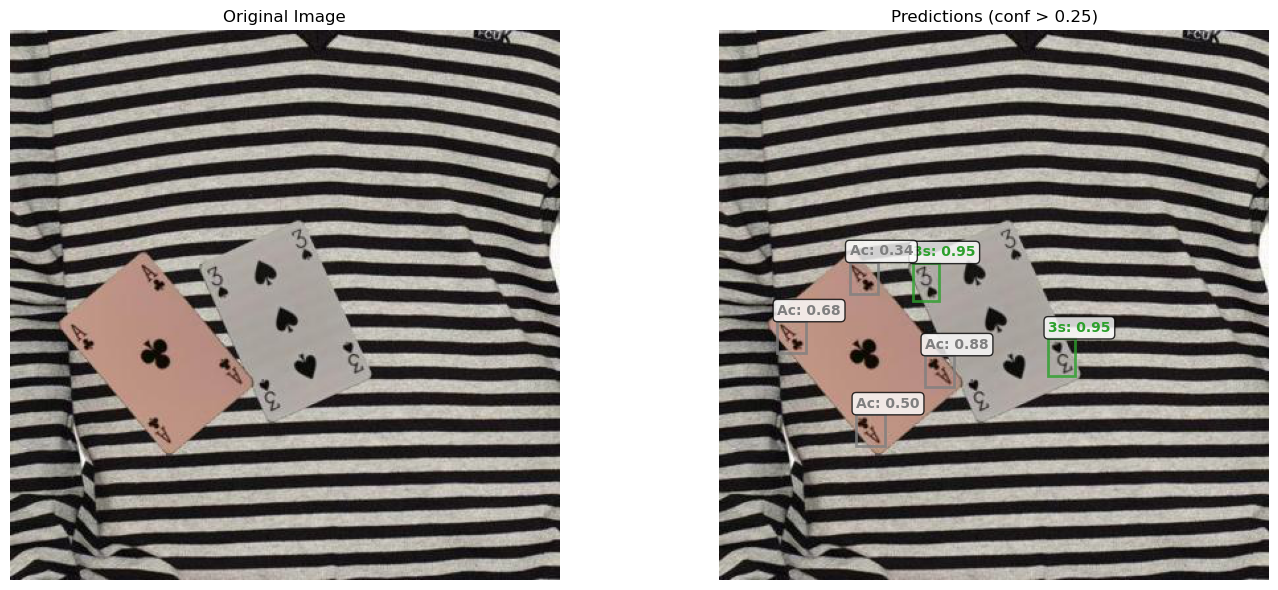


Detection Summary for 946641658_jpg.rf.64e9637f9539dc5a7457db362304afc0.jpg:
Number of detections: 6
  1. 3s: 0.950
  2. 3s: 0.946
  3. Ac: 0.883
  4. Ac: 0.676
  5. Ac: 0.503
  6. Ac: 0.339


In [17]:
# Test the model on a specific image and visualize results
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def test_and_visualize_prediction(model, image_path, conf_threshold=0.25):
    """
    Test model on a single image and visualize predictions
    """
    #prediction
    results = model.predict(source=image_path, conf=conf_threshold, save=False)
    
    #load original image
    image = Image.open(image_path)
    
    #create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    #original image
    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    #image with predictions
    ax2.imshow(image)
    ax2.set_title(f'Predictions (conf > {conf_threshold})')
    ax2.axis('off')
    
    #image dimensions
    img_width, img_height = image.size
    
    #colors for different classes
    colors = plt.cm.tab10(np.linspace(0, 1, len(data_config['names'])))
    
    #draw bounding boxes and labels
    if len(results[0].boxes) > 0:
        for box in results[0].boxes:
            #box coordinates (xyxy format)
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            
            #confidence and class
            conf = box.conf[0].cpu().numpy()
            class_id = int(box.cls[0].cpu().numpy())
            class_name = data_config['names'][class_id]
            
            #draw rectangle
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                   linewidth=2, edgecolor=colors[class_id], 
                                   facecolor='none', alpha=0.8)
            ax2.add_patch(rect)
            
            #add label with confidence
            label = f'{class_name}: {conf:.2f}'
            ax2.text(x1, y1-5, label, 
                    color=colors[class_id], fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nDetection Summary for {os.path.basename(image_path)}:")
    print(f"Number of detections: {len(results[0].boxes)}")
    
    if len(results[0].boxes) > 0:
        for i, box in enumerate(results[0].boxes):
            conf = box.conf[0].cpu().numpy()
            class_id = int(box.cls[0].cpu().numpy())
            class_name = data_config['names'][class_id]
            print(f"  {i+1}. {class_name}: {conf:.3f}")

#sample image from validation set
val_images_dir = os.path.join(dataset_path, 'valid', 'images')
if os.path.exists(val_images_dir):
    #random validation image
    val_images = [f for f in os.listdir(val_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    if val_images:
        test_image = os.path.join(val_images_dir, random.choice(val_images))
        print(f"Testing on: {os.path.basename(test_image)}")
        test_and_visualize_prediction(model, test_image, conf_threshold=0.25)
    else:
        print("No validation images found")
else:
    print("Validation images directory not found")